# Wide ResNet Experiments

### Рассмотрим модель Wide ResNet, которую от обычного ResNet отличает увеличенное число фильтров в конволлюционных блоках. Модель была предложена в статье https://arxiv.org/abs/1605.07146



### Авторы исследовали множество моделей на основе классического ResNet, введя параметризацию (k, N), где k - фактор, увеличивающий ширину сети,  N - фактор, увеличивающий глубину.
![title](wide1.png)

### Давайте убедимся, что увеличение ширины сети действительно позитивно сказывается на качестве и скорости обучения ResNet-а. Для этого обучим несколько сетей со сравнимым числом параметров  и разными конфигурациями глубины и ширины.

In [1]:
%matplotlib inline
%env CUDA_VISIBLE_DEVICES = 1

env: CUDA_VISIBLE_DEVICES=1


In [2]:
import sys

import numpy as np
import os
import blosc

import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

import os
import blosc
import simplejson
import json
import pickle

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm
from tensorflow.contrib.layers import xavier_initializer_conv2d
from scipy.interpolate import spline
from collections import defaultdict

sys.path.append("..")
    
from dataset import DatasetIndex, Dataset
from dataset import Batch, action, model, inbatch_parallel
from wide import MnistBatch
from wide import draw_stats

In [3]:
def parameters_count(ppl):
    all_layers = ppl.get_model_by_name('resnet')[-1][-1].graph.get_collection('trainable_variables')
    n_parameters = 0
    for layer in all_layers:
        current_n = 1
        for dim_shape in (layer.get_shape().as_list()):
            current_n *= dim_shape
        n_parameters += current_n
    return (n_parameters)

### Загрузим данные MNIST:

In [4]:
src = 'C:/Users/Dari/Documents/az_training/task_03'

with open(os.path.join(src, 'mnist_pics.blk'), 'rb') as file:
    full_imgs = blosc.unpack_array(file.read())
    
with open(os.path.join(src, 'mnist_labels.blk'), 'rb') as file:
    full_labs = blosc.unpack_array(file.read())
    
src = (np.reshape(full_imgs, (65000, 28, 28)), full_labs)

# LEN_MNIST = 65000
# indy = DatasetIndex(np.arange(LEN_MNIST))

# mnistset = Dataset(indy, batch_class=MnistBatch)
# mnistset.cv_split([0.9, 0.1])

ix = DatasetIndex(range(58500))
train_dataset = Dataset(ix, MnistBatch)


In [5]:
test_ix = DatasetIndex(range(65000-58500))
test_dataset = Dataset(test_ix, MnistBatch)

In [6]:
# widening_factors = [2, 1]
# length_factors = [1, 1]
# add_blocks = [2, 8]

# test_losses_lengths = defaultdict(list)
# test_accs_lengths = defaultdict(list)
# train_times_lengths = defaultdict(list)
pipelines_dict_length  = defaultdict(list)

n_iterations = 800

In [7]:
widening_factors = [3]
length_factors = [1]
add_blocks = [0]

for index, wid_factor in enumerate(widening_factors):
    config = {'resnet':{'conv_initializer':tf.contrib.layers.variance_scaling_initializer(factor=2.0),\
                    'dense_initializer':tf.contrib.layers.variance_scaling_initializer(factor=2.0),\
                    'factor':wid_factor, \
                    'length_factor':length_factors[index], \
                    'add_blocks':add_blocks[index]}}
    stats = []
    loss_history = []
    time_list = []

    ppl = (train_dataset.pipeline(config=config).
       train_res(loss_history, stats, src[0][:58500], full_labs[:58500], time_list))

    current_loss = []
    current_acc = []
    test_ppl = (test_dataset.p.import_model('resnet', ppl).update_stats(current_loss, current_acc, src[0][58500:], full_labs[58500:]))

    print('current config', config['resnet']['factor'])


    for i in tqdm(range(n_iterations)):
        ppl.next_batch(100, n_epochs=None, shuffle=2)
        test_ppl.next_batch(100, n_epochs=None, shuffle=2)

    print ('time ', np.mean(np.array(time_list)))

    test_losses_lengths[str(44) + '+' + str(index+1)] = current_loss
    test_accs_lengths[str(44) + '+' + str(index+1)] = current_acc
    train_times_lengths[str(44) + '+' + str(index+1)] = time_list

    pipelines_dict_length[str(44) + '+' + str(index+1)]  = ppl

current config 3


  0%|                                                                                          | 0/800 [00:00<?, ?it/s]

48 48
[None, 7, 7, 48]
[None, 7, 7, 48]
96 96
[None, 7, 7, 96]
[None, 7, 7, 96]
192 192
[None, 7, 7, 192]
[None, 7, 7, 192]


  0%|                                                                                | 1/800 [00:07<1:33:37,  7.03s/it]


KeyboardInterrupt: 

In [23]:
for index, wid_factor in enumerate(widening_factors):
    config = {'resnet':{'conv_initializer':tf.contrib.layers.variance_scaling_initializer(factor=2.0),\
                    'dense_initializer':tf.contrib.layers.variance_scaling_initializer(factor=2.0),\
                    'factor':wid_factor, \
                    'length_factor':length_factors[index], \
                    'add_blocks':add_blocks[index]}}
    stats = []
    loss_history = []
    time_list = []

    ppl = (train_dataset.pipeline(config=config).
       train_res(loss_history, stats, src[0][:58500], full_labs[:58500], time_list))

    current_loss = []
    current_acc = []
    test_ppl = (test_dataset.p.import_model('resnet', ppl).update_stats(current_loss, current_acc, src[0][58500:], full_labs[58500:]))

    print('current config', config['resnet']['factor'])


    for i in tqdm(range(n_iterations)):
        ppl.next_batch(100, n_epochs=None, shuffle=2)
        test_ppl.next_batch(100, n_epochs=None, shuffle=2)

    print ('time ', np.mean(np.array(time_list)))

    test_losses_lengths[str(22) + '+' + str(index+1)] = current_loss
    test_accs_lengths[str(22) + '+' + str(index+1)] = current_acc
    train_times_lengths[str(22) + '+' + str(index+1)] = time_list

    pipelines_dict_length[str(22) + '+' + str(index+1)]  = ppl

current config 2


  0%|                                                                                          | 0/400 [00:00<?, ?it/s]

32 32
64 64
128 128
128 128
128 128


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [05:59<00:00,  1.11it/s]


time  0.387591849945
current config 1


  0%|                                                                                          | 0/400 [00:00<?, ?it/s]

16 16
32 32
64 64
64 64
64 64
64 64
64 64
64 64
64 64
64 64
64 64


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [06:02<00:00,  1.10it/s]


time  0.41111079648


In [9]:
widening_factors = [3 ,2, 1]
length_factors = [1, 2, 8]
add_blocks = [0, 0, 0]

In [10]:
for index, wid_factor in enumerate(widening_factors):
    config = {'resnet':{'conv_initializer':tf.contrib.layers.variance_scaling_initializer(factor=2.0),\
                    'dense_initializer':tf.contrib.layers.variance_scaling_initializer(factor=2.0),\
                    'factor':wid_factor, \
                    'length_factor':length_factors[index], \
                    'add_blocks':add_blocks[index]}}
    stats = []
    loss_history = []
    time_list = []

    ppl = (train_dataset.pipeline(config=config).
       train_res(loss_history, stats, src[0][:58500], full_labs[:58500], time_list))

    current_loss = []
    current_acc = []
    test_ppl = (test_dataset.p.import_model('resnet', ppl).update_stats(current_loss, current_acc, src[0][58500:], full_labs[58500:]))

    print('current config', config['resnet']['factor'])


    for i in tqdm(range(n_iterations)):
        ppl.next_batch(100, n_epochs=None, shuffle=2)
        test_ppl.next_batch(100, n_epochs=None, shuffle=2)

    print ('time ', np.mean(np.array(time_list)))

    test_losses_lengths[str(index) + '+' + str(index)] = current_loss
    test_accs_lengths[str(index) + '+' + str(index)] = current_acc
    train_times_lengths[str(index) + '+' + str(index)] = time_list

    pipelines_dict_length[str(index) + '+' + str(index)]  = ppl

current config 3


  0%|                                                                                          | 0/400 [00:00<?, ?it/s]

48 48
96 96
192 192


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [04:12<00:00,  1.59it/s]


time  0.276595314329
current config 2


  0%|                                                                                          | 0/400 [00:00<?, ?it/s]

32 32
32 32
64 64
64 64
128 128
128 128


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [04:49<00:00,  1.40it/s]


time  0.316600982244
current config 1


  0%|                                                                                          | 0/400 [00:00<?, ?it/s]

16 16
16 16
16 16
16 16
16 16
16 16
16 16
16 16
32 32
32 32
32 32
32 32
32 32
32 32
32 32
32 32
64 64
64 64
64 64
64 64
64 64
64 64
64 64
64 64


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [07:25<00:00,  1.28s/it]


time  0.507331908985


# Результаты

### Ниже представлены графики лоссов сетей с разной конфигурацией. Видно, что сеть самая широкая сеть (к=3, l = 8) обучается быстрее всего. 

### Также можно заметить, что сеть с большим N, т.е. кратным увеличением блоков конволюций каждого размера работает заметно хуже чем, например, с добавлением 8 блоков в конец сети (т.е. увеличением числа конволюций с фильтрами большего размера). Т.е. увеличение числа конволюций с размером фильтра 16 * 16 оказывается не только бесполезным, но и вредным, замедляя время обучения. 

#### Однако это верно только для большого числа конволюций. Время обучения сети с двукратным увеличением числа одинаковых блоков (N=2) и расширение  (k=2) практически совпадает c добавлением 2 блоков в конец широкой сети (k=2, add=2)

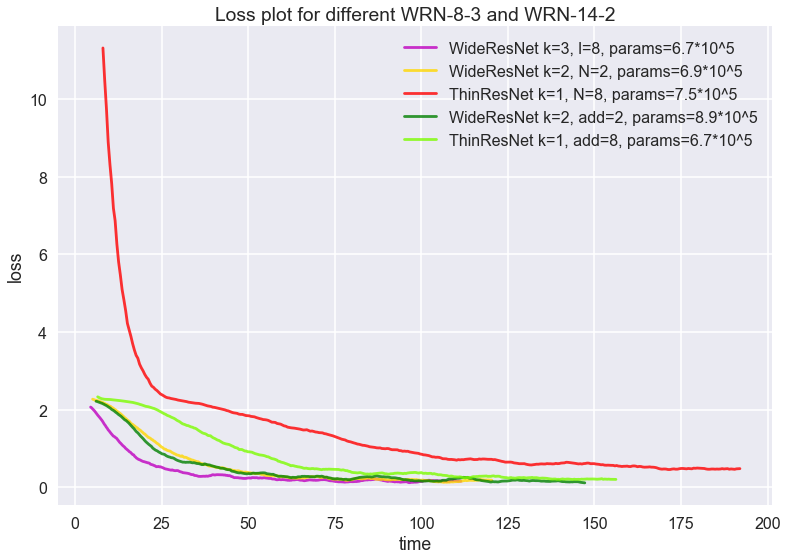

In [59]:
plt.style.use('seaborn-poster')
plt.title('Loss plot for different ResNet architectures')
cols = ['m', 'gold', 'r', 'g', 'lawngreen', 'b' , 'c', 'midnightblue']
# keys_300 = ['0+0', '22+0', '22+1']
# keys_300 = ['22+1', '22+2']
keys_300 = ['0+0', '1+1', '2+2', '22+1', '22+2']
factors = ['WideResNet k=3, l=8, params=6.7*10^5', 'WideResNet k=2, N=2, params=6.9*10^5', 'ThinResNet k=1, N=8, params=7.5*10^5', 'WideResNet k=2, add=2, params=8.9*10^5', 'ThinResNet k=1, add=8, params=6.7*10^5']

for index, current in enumerate(keys_300):
    current_time = np.cumsum(train_times_lengths[current])
    current_loss = test_losses_lengths[current]
#     if index < 6 and index >0:
#         continue
    smoothed_current = []
    for i in range(10, len(current_loss) - 10):
        smoothed_current.append(np.mean(current_loss[i-10:i+10]))

#     plt.plot(current_time[:], current_loss[:], c=cols[index], label = keys_300[index], alpha=0.8)
    plt.plot(current_time[15:len(smoothed_current)], smoothed_current[15:], c=cols[index], label = factors[index], alpha=0.8)

plt.legend()
plt.xlabel('time')
plt.ylabel('loss')
plt.show()

### Поэтому будет честнее сравнивать широкую сеть с не заведомо плохой глубокой "тонкой" сетью, а с той, глубина которой увеличена за счет добавления слоев в конец. 

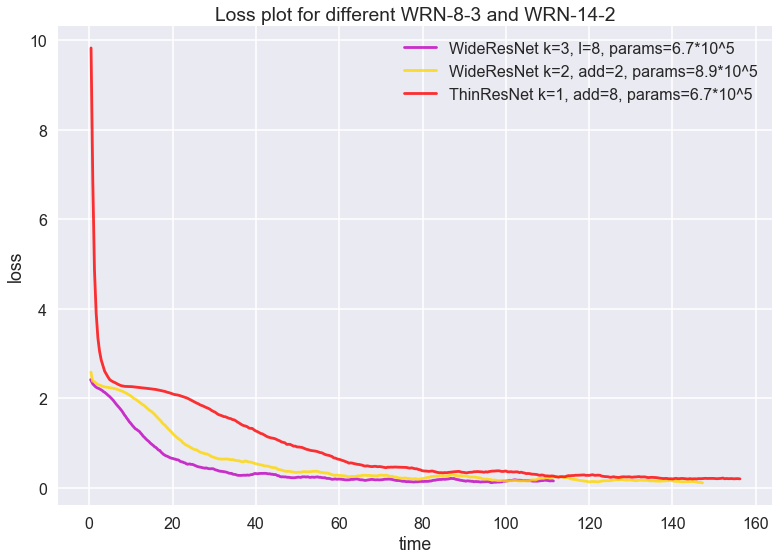

In [60]:
plt.style.use('seaborn-poster')
plt.title('Loss plot for different WRN-8-3 and WRN-14-2')
cols = ['m', 'gold', 'r', 'g', 'lawngreen', 'b' , 'c', 'midnightblue']
keys_300 = ['0+0', '22+1', '22+2']
# keys_300 = ['22+0', '1+1']

factors = ['WideResNet k=3, l=8, params=6.7*10^5', 'WideResNet k=2, add=2, params=8.9*10^5', 'ThinResNet k=1, add=8, params=6.7*10^5']
for index, current in enumerate(keys_300):
    current_time = np.cumsum(train_times_lengths[current])
    current_loss = test_losses_lengths[current]
#     if index < 6 and index >0:
#         continue
    smoothed_current = []
    for i in range(10, len(current_loss) - 10):
        smoothed_current.append(np.mean(current_loss[i-10:i+10]))

#     plt.plot(current_time[:], current_loss[:], c=cols[index], label = keys_300[index], alpha=0.8)
    plt.plot(current_time[0:len(smoothed_current)], smoothed_current[0:], c=cols[index], label = factors[index], alpha=0.8)

plt.legend()
plt.xlabel('time')
plt.ylabel('loss')
plt.show()

In [64]:
# parameters count 
for ppl_i in pipelines_dict_length.keys():
    print(ppl_i, ' ', parameters_count(pipelines_dict_length[ppl_i]))

22+1   894154
22+2   669178


In [18]:
with open("loss_results.txt", "wb") as a:
    pickle.dump(test_losses_lengths, a)
    
with open("accs_results.txt", "wb") as a:
    pickle.dump(test_accs_lengths, a)

with open("time_results.txt", "wb") as a:
    pickle.dump(train_times_lengths, a)

In [7]:
with open("loss_results.txt", "rb") as a:
    test_losses_lengths = pickle.load(a)
    
with open("accs_results.txt", "rb") as a:
    test_accs_lengths = pickle.load(a)

with open("time_results.txt", "rb") as a:
    train_times_lengths = pickle.load(a)

In [61]:
from wide_resnet import MnistBatchBottleneck

In [62]:
train_dataset = Dataset(ix, MnistBatchBottleneck)
test_dataset = Dataset(test_ix, MnistBatchBottleneck)

In [ ]:
stats = []
loss_history = []
time_list = []
n_iterations = 400

config = {'resnet':{'conv_initializer':tf.contrib.layers.variance_scaling_initializer(factor=2.0),\
                'dense_initializer':tf.contrib.layers.variance_scaling_initializer(factor=2.0),\
                'factor':3, \
                'length_factor':1, \
                'add_blocks':1}}
    
ppl = (train_dataset.pipeline(config=config).
   train_res(loss_history, stats, src[0][:58500], full_labs[:58500], time_list))

current_loss = []
current_acc = []
test_ppl = (test_dataset.p.import_model('resnet', ppl).update_stats(current_loss, current_acc, src[0][58500:], full_labs[58500:]))

print('current config', config['resnet']['factor'])


for i in tqdm(range(n_iterations)):
    ppl.next_batch(100, n_epochs=None, shuffle=2)
    test_ppl.next_batch(100, n_epochs=None, shuffle=2)

print ('time ', np.mean(np.array(time_list)))

In [13]:
test_losses_lengths[str(33) + '+' + str(3)] = current_loss
test_accs_lengths[str(33) + '+' + str(3)] = current_acc
train_times_lengths[str(33) + '+' + str(3)] = time_list

pipelines_dict_length[str(33) + '+' + str(3)]  = ppl

In [18]:
stats = []
loss_history = []
time_list = []
n_iterations = 400

config = {'resnet':{'conv_initializer':tf.contrib.layers.variance_scaling_initializer(factor=2.0),\
                'dense_initializer':tf.contrib.layers.variance_scaling_initializer(factor=2.0),\
                'factor':1, \
                'length_factor':1, \
                'add_blocks':9}}
    
ppl = (train_dataset.pipeline(config=config).
   train_res(loss_history, stats, src[0][:58500], full_labs[:58500], time_list))

current_loss = []
current_acc = []
test_ppl = (test_dataset.p.import_model('resnet', ppl).update_stats(current_loss, current_acc, src[0][58500:], full_labs[58500:]))

print('current config', config['resnet']['factor'])


for i in tqdm(range(n_iterations)):
    ppl.next_batch(100, n_epochs=None, shuffle=2)
    test_ppl.next_batch(100, n_epochs=None, shuffle=2)

print ('time ', np.mean(np.array(time_list)))

test_losses_lengths[str(33) + '+' + str(1)] = current_loss
test_accs_lengths[str(33) + '+' + str(1)] = current_acc
train_times_lengths[str(33) + '+' + str(1)] = time_list

pipelines_dict_length[str(33) + '+' + str(1)]  = ppl

current config 1



  0%|                                                                                          | 0/400 [00:00<?, ?it/s]

16 16
32 32
64 64
64 64
64 64
64 64
64 64
64 64
64 64
64 64
64 64
64 64



100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [06:42<00:00,  1.03s/it]


time  0.456887866997


In [17]:
# # parameters count 
# for ppl_i in pipelines_dict_length.keys():
#     print(ppl_i, ' ', parameters_count(pipelines_dict_length[ppl_i]))

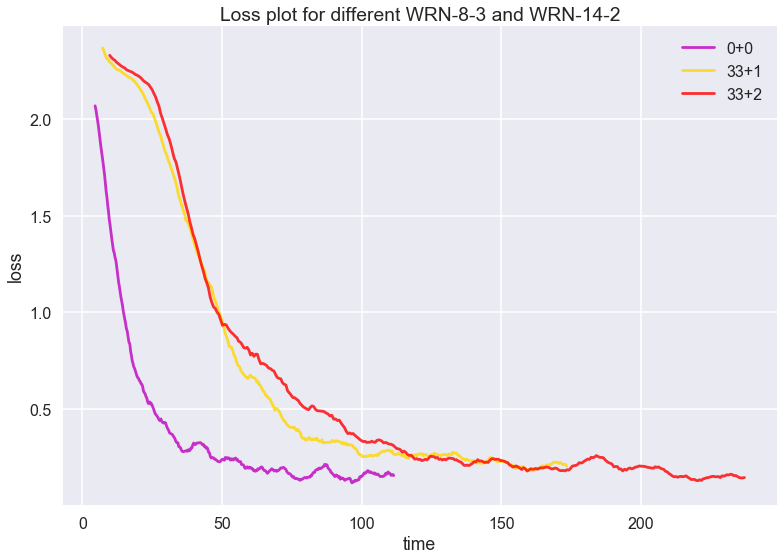

In [16]:
plt.style.use('seaborn-poster')
plt.title('Loss plot for different WRN with bottleneck')
cols = ['m', 'gold', 'r', 'g', 'lawngreen', 'b' , 'c', 'midnightblue']
keys_300 = ['0+0', '33+1', '33+2']
factors = ['WideResNet k=3, l=8, params=6.7*10^5', 'WideResNet k=2, N=2, params=6.9*10^5', 'ThinResNet k=1, N=8, params=7.5*10^5', 'WideResNet k=2, add=2, params=8.9*10^5', 'ThinResNet k=1, add=8, params=6.7*10^5']

for index, current in enumerate(keys_300):
    current_time = np.cumsum(train_times_lengths[current])
    current_loss = test_losses_lengths[current]
#     if index < 6 and index >0:
#         continue
    smoothed_current = []
    for i in range(10, len(current_loss) - 10):
        smoothed_current.append(np.mean(current_loss[i-10:i+10]))

#     plt.plot(current_time[:], current_loss[:], c=cols[index], label = keys_300[index], alpha=0.8)
    plt.plot(current_time[15:len(smoothed_current)], smoothed_current[15:], c=cols[index], label = keys_300[index], alpha=0.8)

plt.legend()
plt.xlabel('time')
plt.ylabel('loss')
plt.show()

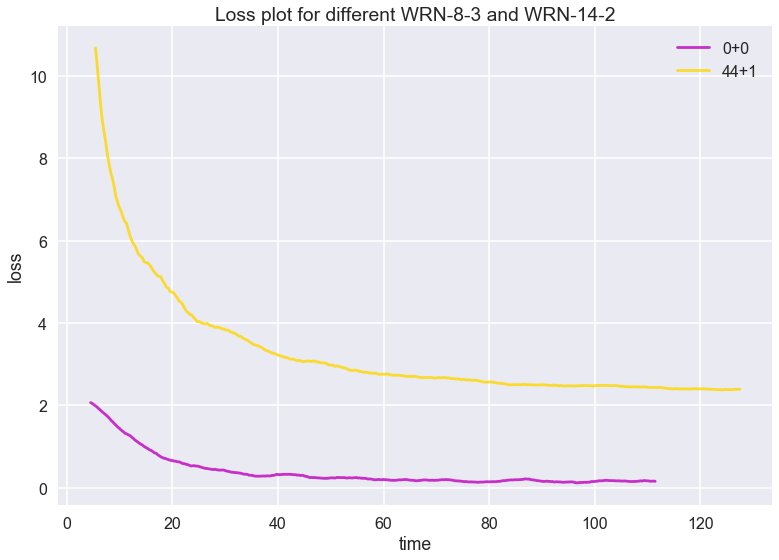

In [9]:
plt.style.use('seaborn-poster')
plt.title('Loss plot for different WRN-8-3 and WRN-14-2')
cols = ['m', 'gold', 'r', 'g', 'lawngreen', 'b' , 'c', 'midnightblue']
# keys_300 = ['0+0', '22+0', '22+1']
# keys_300 = ['22+1', '22+2']
keys_300 = ['0+0', '44+1']
factors = ['WideResNet k=3, l=8, params=6.7*10^5', 'WideResNet k=2, N=2, params=6.9*10^5', 'ThinResNet k=1, N=8, params=7.5*10^5', 'WideResNet k=2, add=2, params=8.9*10^5', 'ThinResNet k=1, add=8, params=6.7*10^5']

for index, current in enumerate(keys_300):
    current_time = np.cumsum(train_times_lengths[current])
    current_loss = test_losses_lengths[current]
#     if index < 6 and index >0:
#         continue
    smoothed_current = []
    for i in range(10, len(current_loss) - 10):
        smoothed_current.append(np.mean(current_loss[i-10:i+10]))

#     plt.plot(current_time[:], current_loss[:], c=cols[index], label = keys_300[index], alpha=0.8)
    plt.plot(current_time[15:len(smoothed_current)], smoothed_current[15:], c=cols[index], label = keys_300[index], alpha=0.8)

plt.legend()
plt.xlabel('time')
plt.ylabel('loss')
plt.show()